In [1]:
import torch.nn as nn
import torch
from tqdm.notebook import tqdm

# %% Generator
class Generator(nn.Module):
    def __init__(self, classCount, dimLatent):
        super(Generator, self).__init__()
        self.classCount = classCount
        self.dimLatent = dimLatent
        self.labelEmbedding = nn.Embedding(num_embeddings = self.classCount, embedding_dim = self.classCount)
        self.img_shape = (1, 24)
        self.model = nn.Sequential(
            # 1st layer
            nn.Linear(in_features = self.classCount + self.dimLatent, out_features = 64),
            nn.LeakyReLU(),
            # 2nd layer
            nn.Linear(in_features = 64, out_features = 128),
            nn.LeakyReLU(),
            # 3rd layer
            nn.BatchNorm1d(num_features = 128, momentum = 0.8),
            # 4th layer
            nn.Linear(in_features = 128, out_features = 64),
            nn.LeakyReLU(),
            # 5th layer
            nn.Linear(in_features = 64, out_features = 24)
        )
    
    def forward(self, noise, labels):
        z = torch.cat((self.labelEmbedding(labels), noise), -1)
        x = self.model(z)
        return x

# %% Discriminator
class Discriminator(nn.Module):
    def __init__(self, classCount, featureCount):
        super(Discriminator, self).__init__()
        self.classCount = classCount
        self.featureCount = featureCount
        self.labelEmbedding = nn.Embedding(num_embeddings = self.classCount, embedding_dim = self.classCount)
        self.adv_loss = torch.nn.BCELoss()
        self.model = nn.Sequential(
            # 1st layer
            nn.Linear(in_features = self.classCount + self.featureCount, out_features = 64),
            nn.LeakyReLU(),
            # 2nd layer
            nn.Linear(in_features = 64, out_features = 128),
            nn.LeakyReLU(),
            # 3rd layer
            nn.Linear(in_features = 128, out_features = 128),
            nn.LeakyReLU(),
            # 4th layer
            nn.Linear(in_features = 128, out_features = 64),
            nn.LeakyReLU(),
            # 5th layer
            nn.Dropout(p = 0.4),
            # 6th layer
            nn.Linear(in_features = 64, out_features = 1),
            nn.Sigmoid()
        )
    
    def forward(self, timeSeries, labels):
        x = torch.cat((timeSeries, self.labelEmbedding(labels)), -1)
        return self.model(x)
    
    def loss(self, output, label):
        return self.adv_loss(output, label)

# %% GAN
class GAN(object):
    def __init__(self, device, dataLoader, classCount, dimLatent, featureCount):
        self.device = device
        self.dataLoader = dataLoader
        self.classCount = classCount
        self.dimLatent = dimLatent
        self.featureCount = featureCount
        self.netGen = Generator(classCount, dimLatent)
        self.netGen.to(self.device)
        self.netDis = Discriminator(classCount, featureCount)
        self.netDis.to(self.device)
    
    def create_optim(self, lr):
        #self.optimGen = torch.optim.Adam(params = self.netGen.parameters(), lr = lr)
        #self.optimDis = torch.optim.Adam(params = self.netDis.parameters(), lr = lr)
        self.optimGen = torch.optim.Adam(params = filter(lambda p: p.requires_grad, self.netGen.parameters()), lr = lr)
        self.optimDis = torch.optim.Adam(params = filter(lambda p: p.requires_grad, self.netDis.parameters()), lr = lr)

    def to_onehot(self, var, dim):
        res = torch.zeros((var.shape[0], dim), device = self.device)
        res[range(var.shape[0]), var] = 1.
        return res

    def train(self, epochs):
        self.netGen.train()
        self.netDis.train()
        for item in tqdm(range(epochs)):
            for batchIdx, (data, target) in enumerate(self.dataLoader):
                data = torch.stack(data).T
                data, target = data.to(device = self.device, dtype = torch.float32), target.to(device = self.device)
                batchSize = data.size(0)
                labelReal = torch.full((batchSize, 1), 1., device = self.device)
                labelFake = torch.full((batchSize, 1), 0., device = self.device)
                # Train generator
                self.netGen.zero_grad()
                zNoise = torch.randn(batchSize, self.dimLatent, device = self.device)
                xLabelsFake = torch.randint(0, self.classCount, (batchSize,), device = self.device)
                xFake = self.netGen(zNoise, xLabelsFake)
                yFakeGen = self.netDis(xFake, xLabelsFake)
                lossGen = self.netDis.loss(yFakeGen, labelReal)
                lossGen.backward()
                self.optimGen.step()
                # Train discriminator
                self.netDis.zero_grad()  
                yReal = self.netDis(data, target)
                realLossDis = self.netDis.loss(yReal, labelReal)
                yFakeDis = self.netDis(xFake.detach(), xLabelsFake)
                fakeLossDis = self.netDis.loss(yFakeDis, labelFake)
                lossDis = (realLossDis + fakeLossDis)/2
                lossDis.backward()
                self.optimDis.step()

    def create_sample(self, labels):
        zNoise = torch.randn(len(labels), self.dimLatent, device = self.device)
        xNew = self.netGen(zNoise, torch.tensor(labels))
        return xNew

# %% Main function
def create_model(device, dataLoader, classCount, dimLatent, featureCount, learningRate, epochs):
    device = torch.device(device)
    model = GAN(device, dataLoader, classCount, dimLatent, featureCount)
    model.create_optim(lr = learningRate)
    model.train(epochs = epochs)
    return model

In [2]:
import pandas as pd
from preprocessing import remove_incomplete_days
from sklearn.preprocessing import minmax_scale
import torch

df_loadProfiles = pd.read_parquet(r'data/load_profiles.parquet.gzip')
df_loadProfiles = remove_incomplete_days(df_loadProfiles)

profile = '1163'
df_temp = df_loadProfiles.pivot_table(values = profile, index = ['date', 'month of the year', 'day off'], columns = 'hour of the day').reset_index()

labels = list((df_temp['month of the year'].astype(str) + df_temp['day off'].astype(str)).astype(int))
label_dict = {}
num = 0
for idx, item in enumerate(labels):
    if item not in label_dict:
        label_dict[item] = num
        num += 1
    labels[idx] = label_dict[item]

df_temp.drop(['date', 'month of the year', 'day off'], axis = 1, inplace = True)
df_temp = pd.DataFrame(minmax_scale(df_temp, feature_range = (0, 1), axis = 1))
timeSeries = df_temp.values.tolist()
dataLoader = torch.utils.data.DataLoader([[timeSeries[i], labels[i]] for i in range(len(labels))], shuffle = True, batch_size = 50)

In [3]:
model = create_model(device = 'cpu', dataLoader = dataLoader, classCount = 24, dimLatent = 20, featureCount = 24, learningRate = 4e-4, epochs = 20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

##### Fake data

<AxesSubplot: >

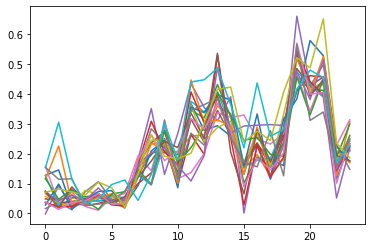

In [4]:
import matplotlib.pyplot as plt

pd.DataFrame(model.create_sample([11]*20).detach().numpy()).T.plot(legend = False)

##### Real data

<AxesSubplot: >

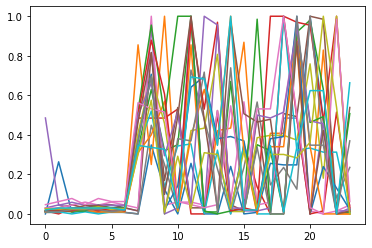

In [5]:
df_temp[[item == 11 for item in labels]].iloc[:20].T.plot(legend = False)